# Statistiques descriptives : la compréhension du corpus de questions

Idée : comprendre la structure du corpus, identifier ses limites

## Préliminaires : importations et définitions utiles pour la suite

On commence par installer les modules pour la compatibilité :

In [ ]:
!pip install geoviews
!pip install geopandas
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install wordcloud

On importe ensuite ce dont on aura besoin : 

In [148]:
import matplotlib.pyplot as plt
import pandas as pd

import geoviews
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter

import wordcloud
import numpy as np
import io
import requests
import PIL
import matplotlib.pyplot as plt
import random

On définit ensuite le set de couleur qui sera utilisé dans les graphes suivants, en particulier pour la lisibilité des groupes politiques : 

In [149]:
dict_couleurs = {'Libertés, Indépendants, Outre-mer et Territoires': 'grey',
         'Les Républicains': 'blue',
         'Démocrate (MoDem et Indépendants)': 'orange',
         'Renaissance': 'yellow',
         'Gauche démocrate et républicaine - NUPES': 'red',
         'La France insoumise - Nouvelle Union Populaire écologique et sociale': 'purple',
         'Rassemblement National': 'black',
         'Horizons et apparentés': 'lightblue',
         'Écologiste - NUPES': 'green',
         'Socialistes et apparentés': 'pink',
         'Non inscrit': 'grey'}

default_color = 'blue'

Importation de la donnée nécessaire pour la suite :

In [150]:
# Charger le fichier CSV dans un DataFrame
df_questions = pd.read_csv('/Users/iokanaanbelfis-simon/PythonPourLaDataScience/Datascrapping/data_cleaned.csv', encoding='utf-8', sep='|')

# Afficher les premières lignes du DataFrame
df_questions.head()

,id,groupe,nom,ministère_interrogé,rubrique,titre,date,question,question_clean
0,1,"Libertés, Indépendants, Outre-mer et Territoires",M. Christophe Naegelen,Agriculture et souveraineté alimentaire,animaux,Cohabitation entre les randonneurs et les patous,05/07/2022,M. Christophe Naegelen interroge M. le ministr...,interroger agriculture souveraineté alimentair...
1,2,Les Républicains,M. Pierre Cordier,Transition écologique et cohésion des territoires,chasse et pêche,Pratique de la vénerie sous terre pour la régu...,05/07/2022,M. Pierre Cordier appelle l'attention de Mme l...,appeler transition écologique cohésion territo...
2,3,Démocrate (MoDem et Indépendants),M. Frédéric Petit,Armées,défense,Défense - Union européenne - SCAF - MGCS - coo...,05/07/2022,M. Frédéric Petit appelle l'attention de M. le...,appeler armée projet européen coopération défe...
3,4,Renaissance,Mme Marie-Pierre Rixain,Comptes publics,eau et assainissement,Recouvrement des impayés de redevances d'assai...,05/07/2022,Mme Marie-Pierre Rixain appelle l'attention de...,appeler déléguer auprès économie finance souve...
4,5,"Libertés, Indépendants, Outre-mer et Territoires",M. Christophe Naegelen,Éducation nationale et jeunesse,enseignement,Conditions d'embauche d'assistants d'éducation...,05/07/2022,M. Christophe Naegelen interroge M. le ministr...,interroger éducation national jeunesse décret ...


Importation de la correspondance député-département : 

In [151]:
departement_mp = {'Ain': ['Damien Abad', 'Xavier Breton', 'Jérôme Buisson', 'Romain Daubié', 'Olga Givernet'], 'Isère': ['Caroline Abadie', 'Marie Battistel', 'Cyrielle Chatelain', 'Servane Hugues', 'Jérémie Iordanoff', 'Format de chaîne non reconnu.', 'Alexis Jolly', 'Élisa Martin', 'Format de chaîne non reconnu.', 'Yannick Neuder'], 'Seine': ['Nadège Abomangoli', 'Damien Adam', 'Clémentine Autain', 'Xavier Batut', 'Soumya Bourouaha', 'Format de chaîne non reconnu.', 'Éric Coquerel', 'Alexis Corbière', 'Alma Dufour', 'Olivier Faure', 'Raquel Garrido', 'Hadrien Ghomi', 'Sébastien Jumel', 'Format de chaîne non reconnu.', 'Bastien Lachaud', 'Maxime Laisney', 'Jean Lecoq', 'Jérôme Legavre', 'Patricia Lemoine', 'Gérard Leseul', 'Aude Luquet', 'Isabelle Périgault', 'Stéphane Peu', 'Michèle Peyron', 'Thomas Portes', 'Format de chaîne non reconnu.', 'Béatrice Roullaud', 'Ersilia Soudais', 'Jean Thiériot', 'Aurélie Trouvé', 'Frédéric Valletoux', 'Annie Vidal', 'Hubert Wulfranc'], 'Haute': ['Jean Acquaviva', 'Antoine Armand', 'Christine Arrighi', 'Joël Aviragnet', 'Christophe Bentz', 'Christophe Bex', 'Michel Castellani', 'Hadrien Clouet', 'Stéphane Delautrette', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Monique Iborra', 'Damien Maudet', 'Manon Meunier', 'Format de chaîne non reconnu.', 'François Piquemal', 'Jean Portarrieu', 'Véronique Riotton', 'Format de chaîne non reconnu.', 'Xavier Roseren', 'Émeric Salmon', 'Format de chaîne non reconnu.', 'Isabelle Valentin', 'Jean Vigier', 'Corinne Vignon', 'Antoine Villedieu', 'Anne Violland'], 'Doubs': ['Éric Alauzet', 'Laurent Croizier', 'Annie Genevard', 'Géraldine Grangier', 'Nicolas Pacquot'], 'Marne': ['Xavier Albertini', 'Charles Courson', 'Éric Girardin', 'Lise Magnier', 'Laure Miller'], 'Aveyron': ['Laurent Alexandre', 'Stéphane Mazars', 'Jean Rousset'], 'Indre': ['Henri Alfandari', 'Fabienne Colboc', 'Nicolas Forissier', 'Charles Fournier', 'François Jolivet', 'Daniel Labaronne', 'Sabine Thillaye'], 'Bouches': ['Franck Allisio', 'Romain Baubry', 'Manuel Bompard', 'Format de chaîne non reconnu.', 'Hendrik Davi', 'Sébastien Delogu', 'Pierre Dharréville', 'José Gonzalez', 'Mohamed Laqhila', 'Gisèle Lelouis', 'Joëlle Mélin', 'Didier Parakian', 'Anne Petel', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Jean Zulesi'], 'Rhône': ['Gabriel Amard', 'Idir Boumertit', 'Blandine Brocard', 'Anne Brugnera', 'Jean Fugit', 'Marie Garin', 'Thomas Gassilloud', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Alexandre Portier', 'Thomas Rudigoz', 'Nathalie Serre', 'Sarah Tanzilli', 'Alexandre Vincendet'], 'Paris': ['David Amiel', 'Rodrigo Arenas', 'Julien Bayou', 'Fanta Berete', 'Aymeric Caron', 'Clara Chassaniol', 'Sophia Chikirou', 'Maud Gatel', 'Benjamin Haddad', 'Format de chaîne non reconnu.', 'Sarah Legrain', 'Sylvain Maillard', 'Danièle Obono', 'Format de chaîne non reconnu.', 'Sandrine Rousseau', 'Éva Sas', 'Danielle Simonnet', 'Caroline Yadan'], 'Loire': ['Ségolène Amiot', 'Quentin Bataillon', 'Mounir Belhamiti', 'Dino Cinieri', 'Sophie Errante', 'Luc Geismar', 'Yannick Haury', 'Sandrine Josso', 'Andy Kerbrat', 'Julie Laernoes', 'Emmanuel Mandon', 'Jean Raux', 'Jean Taite', 'Andrée Taurinya', 'Matthias Tavel', 'Format de chaîne non reconnu.'], 'Essonne': ['Farida Amrani', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Jérôme Guedj', 'Marie Guévenoux', 'Alexis Izard', 'Antoine Léaument', 'Paul Midy', 'Robin Reda', 'Marie Rixain'], 'Français': ['Pieyre Anglade', 'Format de chaîne non reconnu.', 'Éléonore Caroit', 'Marc Ferracci', 'Anne Genetet', 'Meyer Habib', 'Alexandre Holroyd', 'Amal Lakrafi', 'Frédéric Petit', 'Stéphane Vojetta', 'Christopher Weissberg'], 'Drôme': ['Emmanuelle Anthoine', 'Mireille Clapot', 'Marie Pochon', 'Lisette Pollet'], 'Charente': ['Jean Ardouin', 'Anne Babault', 'Caroline Colombier', 'Olivier Falorni', 'Raphaël Gérard', 'Sandra Marsaud', 'René Pilato', 'Christophe Plassard'], 'Vaucluse': ['Bénédicte Auzanot', 'Catherine Jaouen', 'Hervé Lépinau', 'Marie Lorho', 'Jean Lovisolo'], 'Finistère': ['Erwan Balanant', 'Jean Larsonneur', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Graziella Melchior', 'Liliana Tanguy', 'Mélanie Thomin'], 'Oise': ['Philippe Ballard', 'Michel Guiniot', 'Format de chaîne non reconnu.', 'Maxime Minot', 'Alexandre Sabatou', 'Pierre Vatin', 'Éric Woerth'], 'Mayenne': ['Géraldine Bannier', 'Format de chaîne non reconnu.', 'Guillaume Garot'], 'Guadeloupe': ['Christian Baptiste', 'Élie Califer', 'Max Mathiasin', 'Olivier Serva'], 'Aude': ['Christophe Barthès', 'Frédéric Falcon', 'Julien Rancoule'], 'La': ['Nathalie Bassire', 'Perceval Gaillard', 'Format de chaîne non reconnu.', 'Karine Lebon', 'Frédéric Maillot', 'Philippe Naillet', 'Jean Ratenon'], 'Deux': ['Delphine Batho', 'Jean Fiévet', 'Bastien Marchive'], 'Meurthe': ['Thibault Bazin', 'Martine Étienne', 'Caroline Fiat', 'Philippe Guillemard', 'Emmanuel Lacresse', 'Dominique Potier'], 'Aube': ['Format de chaîne non reconnu.', 'Jordan Guitton', 'Angélique Ranc'], 'Aisne': ['José Beaurain', 'Jean Bricout', 'Jocelyn Dessigny', 'Julien Dive', 'Nicolas Dragon'], 'Moselle': ['Belkhir Belhaddad', 'Format de chaîne non reconnu.', 'Laurent Jacobelli', 'Charlotte Leduc', 'Alexandre Loubet', 'Ludovic Mendes', 'Kévin Pfeffer', 'Isabelle Rauch', 'Vincent Seitlinger'], 'Vendée': ['Béatrice Bellamy', 'Véronique Besse', 'Stéphane Buchou', 'Pierre Henriet', 'Philippe Latombe'], 'Vienne': ['Lisa Belluco', 'Sacha Houlié', 'Pascal Lecamp', 'Nicolas Turquois'], 'Ille': ['Thierry Benoit', 'Mickaël Bouloux', 'Jean Bourgeaux', 'Mathilde Hignet', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Frédéric Mathieu', 'Claudia Rouaux'], 'Yvelines': ['Anne Bergantz', 'Format de chaîne non reconnu.', 'Philippe Emmanuel', 'Nadia Hai', 'Marie Lebec', 'Benjamin Lucas', 'William Martinet', 'Bruno Millienne', 'Karl Olive', 'Béatrice Piron', 'Natalia Pouzyreff', 'Charles Rodwell'], 'Nord': ['Ugo Bernalicis', 'Pierrick Berteloot', 'Guy Bricout', 'Victor Catteau', 'Sébastien Chenu', 'Paul Christophe', 'Christine Decodts', 'Béatrice Descamps', 'Thibaut François', 'Félicie Gérard', 'David Guiraud', 'Vincent Ledoux', 'Brigitte Liso', 'Matthieu Marchio', 'Format de chaîne non reconnu.', 'Adrien Quatennens', 'Fabien Roussel', 'Format de chaîne non reconnu.', 'Violette Spillebout', 'Michaël Taverne', 'Roger Vicot'], 'Gard': ['Philippe Berta', 'Pascale Bordes', 'Yoann Gillet', 'Format de chaîne non reconnu.', 'Pierre Meurin', 'Michel Sala'], 'Pas': ['Bruno Bilde', 'Emmanuel Blairy', 'Pierre Dumont', 'Christine Engrand', 'Philippe Fait', 'Thierry Frappé', 'Format de chaîne non reconnu.', 'Jacqueline Maquet', 'Caroline Parmentier', 'Bertrand Petit', 'Jean Pont', 'Jean Tellier'], 'Val': ['Carlos Bilongo', 'Louis Boyard', 'Émilie Chandler', 'Format de chaîne non reconnu.', 'Frédéric Descrozaille', 'Estelle Folest', 'Format de chaîne non reconnu.', 'Clémence Guetté', 'Michel Herbillon', 'Rachel Keke', 'Format de chaîne non reconnu.', 'Mathieu Lefèvre', 'Naïma Moutchou', 'Mathilde Panot', 'Maud Petit', 'Cécile Rilhac', 'Isabelle Santiago', 'Aurélien Taché', 'Format de chaîne non reconnu.', 'Paul Vannier', 'Guillaume Vuilletet'], 'Pyrénées': ['Sophie Blanc', 'Vincent Bru', 'Format de chaîne non reconnu.', 'Iñaki Echaniz', 'David Habib', 'Florence Lasserre', 'Michèle Martinez', 'Jean Mattei', 'Josy Poueyto', 'Anaïs Sabatini'], 'Calvados': ['Christophe Blanchet', 'Bertrand Bouyx', 'Arthur Delaporte', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Freddy Sertin'], 'Maine': ['Anne Blin', 'Philippe Bolo', 'Format de chaîne non reconnu.', 'Stella Dupont', 'François Gernigon', 'Denis Masséglia', 'Format de chaîne non reconnu.'], 'Var': ['Frédéric Boccaletti', 'Yannick Chenevard', 'Frank Giletti', 'Laure Lavalette', 'Julie Lechanteux', 'Philippe Lottiaux', 'Stéphane Rambaud', 'Philippe Schreck'], 'Savoie': ['Émilie Bonnivard', 'Jean Coulomme', 'Marina Ferrari', 'Vincent Rolland'], 'Cantal': ['Jean Bony', 'Vincent Descœur'], 'Côte': ['Benoît Bordat', 'Hubert Brigand', 'Philippe Frei', 'Didier Martin', 'Didier Paris'], 'Côtes': ['Éric Bothorel', 'Chantal Bouloux', 'Mickaël Cosson', 'Format de chaîne non reconnu.', 'Murielle Lepvraud'], 'Territoire': ['Ian Boucard', 'Florian Chauche'], 'Gironde': ['Florent Boudié', 'Format de chaîne non reconnu.', 'Edwige Diaz', 'Grégoire Fournas', 'Pascal Lavergne', 'Alexandra Martin', 'Sophie Mette', 'Sophie Panonacle', 'Éric Poulliat', 'Format de chaîne non reconnu.', 'Nicolas Thierry', 'Frédéric Zgainski'], 'Hauts': ['Jean Bourlanges', 'Maud Bregeon', 'Céline Calvez', 'Pierre Cazeneuve', 'Elsa Faucillon', 'Claire Guichard', 'Philippe Juvin', 'Virginie Lanlo', 'Format de chaîne non reconnu.', 'Francesca Pasquini', 'Emmanuel Pellerin', 'Aurélien Saintoul', 'Sabrina Sebaihi'], 'Allier': ['Jorys Bovet', 'Yannick Monnet', 'Nicolas Ray'], 'Hautes': ['Pascale Boyer', 'Sylvie Ferrer', 'Joël Giraud', 'Benoît Mournet'], 'Loiret': ['Anthony Brosse', 'Caroline Janvier', 'Thomas Ménagé', 'Mathilde Paris', 'Richard Ramos', 'Stéphanie Rist'], 'Jura': ['Danielle Brulebois', 'Marie Dalloz', 'Justine Gruet'], 'Ardèche': ['Fabrice Brun', 'Format de chaîne non reconnu.', 'Hervé Saulignac'], 'Eure': ['Philippe Brun', 'Timothée Houssin', 'Guillaume Kasbarian', 'Luc Lamirault', 'Laurent Leclercq', 'Katiana Levavasseur', 'Christine Loir', 'Olivier Marleix', 'Kévin Mauvieux'], 'Bas': ['Françoise Buffet', 'Emmanuel Fernandes', 'Patrick Hetzel', 'Stéphanie Kochert', 'Format de chaîne non reconnu.', 'Sandra Regol', 'Charles Sitzenstuhl', 'Bruno Studer', 'Vincent Thiébaut'], 'Tarn': ['Frédéric Cabrolier', 'Karen Erodi', 'Marine Hamelet', 'Valérie Rabault', 'Jean Terlier'], 'Hérault': ['Sylvain Carrière', 'Laurence Cristol', 'Stéphanie Galzy', 'Format de chaîne non reconnu.', 'Emmanuelle Ménard', 'Nathalie Oziol', 'Sébastien Rome', 'Philippe Sorez', 'Patrick Vignal'], 'Guyane': ['Jean Castor', 'Davy Rimane'], 'Landes': ['Lionel Causse', 'Geneviève Darrieussecq', 'Boris Vallaud'], 'Gers': ['Jean Cazeneuve', 'David Taupiac'], 'Polynésie': ['Steve Chailloux', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.'], 'Puy': ['André Chassaigne', 'Delphine Lingemann', 'Marianne Maximi', 'Format de chaîne non reconnu.', 'Laurence Vichnievsky'], 'Loir': ['Roger Chudeau', 'Mathilde Desjonquères', 'Christophe Marion'], 'Alpes': ['Éric Ciotti', 'Format de chaîne non reconnu.', 'Christian Girard', 'Alexandra Martin', 'Alexandra Masson', 'Bryan Masson', 'Éric Pauget', 'Philippe Pradal', 'Michèle Tabarot', 'Lionel Tivoli', 'Léo Walter'], 'Corse': ['Paul Colombani', 'Laurent Marcangeli'], 'Ardennes': ['Pierre Cordier', 'Lionel Vuibert', 'Jean Warsmann'], 'Cher': ['Format de chaîne non reconnu.', 'Loïc Kervran', 'Nicolas Sansu'], 'Saône': ['Josiane Corneloup', 'Benjamin Dirx', 'Louis Margueritte', 'Rémy Rebeyrotte', 'Cécile Untermaier'], 'Lot': ['Annick Cousin', 'Hélène Laporte', 'Michel Lauzzana', 'Aurélien Pradié', 'Huguette Tiegna'], 'Creuse': ['Catherine Couturier'], 'Dordogne': ['Jean Cubertafon', 'Pascale Martin', 'Serge Muller', 'Sébastien Peytavie'], 'Sarthe': ['Julie Delpech', 'Jean Grelier', 'Marietta Karamanli', 'Élise Leboucher', 'Format de chaîne non reconnu.'], 'Somme': ['Ingrid Dordain', 'Emmanuel Maquet', 'Yaël Menache', 'François Ruffin', 'Jean Tanguy'], 'Corrèze': ['Francis Dubois', 'Frédérique Meunier'], 'Nouvelle': ['Philippe Dunoyer', 'Nicolas Metzdorf'], 'Ariège': ['Martine Froger', 'Laurent Panifous'], 'Haut': ['Bruno Fuchs', 'Format de chaîne non reconnu.', 'Brigitte Klinkert', 'Didier Lemaire', 'Hubert Ott', 'Raphaël Schellenberger'], 'Vosges': ['Jean Gaultier', 'Christophe Naegelen', 'David Valence', 'Stéphane Viry'], 'Manche': ['Philippe Gosselin', 'Anna Pic', 'Bertrand Sorre', 'Stéphane Travert'], 'Nièvre': ['Perrine Goulet', 'Patrice Perrot'], 'Meuse': ['Florence Goulet', 'Bertrand Pancher'], 'Yonne': ['Daniel Grenon', 'Julien Odoul', 'André Villiers'], 'Saint': ['Frantz Gumbs', 'Stéphane Lenormand'], 'Martinique': ['Johnny Hajjar', 'Marcellin Nadeau', 'Jean Nilor', 'Jiovanny William'], 'Morbihan': ['Jean Jacques', 'Format de chaîne non reconnu.', 'Format de chaîne non reconnu.', 'Lysiane Métayer', 'Paul Molac', 'Jimmy Pahun'], 'Orne': ['Chantal Jourdan', 'Véronique Louwagie', 'Jérôme Nury'], 'Mayotte': ['Mansour Kamardine', 'Estelle Youssouffa'], 'Lozère': ['Format de chaîne non reconnu.'], 'Wallis': ['Mikaele Seo']}

## Introduction : des fonctions de bases pour la représentation graphique 

Première fonction : tracé d'histogramme à partir d'un dictionnaire, avec une colorisation correcte si les clés sont des groupes politiques :

In [152]:
def plot_top_n_keys(dictionary, n, x, y, title): # fonction unique qui sera utilisée par la suite : gestion de cas pour les couleurs
    sorted_items = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)

    top_n_items = sorted_items[:n]

    keys, values = zip(*top_n_items)

    # Define a default color for categories not in the dictionary
    default_color = 'blue'

    # Create the barplot using the defined colors
    colors = [dict_couleurs.get(cat, default_color) for cat in keys]

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color=colors)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

Deuxième fonction : tracé d'une carte avec des valeurs par département à partir d'un dictionnaire

In [191]:
def trace_carte(dico_dep,title):
    # Load the GeoJSON file containing geometries of French départements
    url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"
    geo = gpd.read_file(url)

    # Merge the GeoDataFrame with the values from the dictionary
    gdf = geo.merge(pd.DataFrame(list(dico_dep.items()), columns=['nom', 'value']), how='left', on='nom')

    gdf['value'].fillna(0, inplace=True)
    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column='value', cmap='GnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    # Add a title and legend
    plt.title(title)
    plt.axis("off")
    plt.show()

## Partie I : Répartition des questions par groupe politique

Pour débuter, nous allons nous intéresser à la proportion de questions aux gouvernements écrites en fonction de l'appartenance à un groupe politique




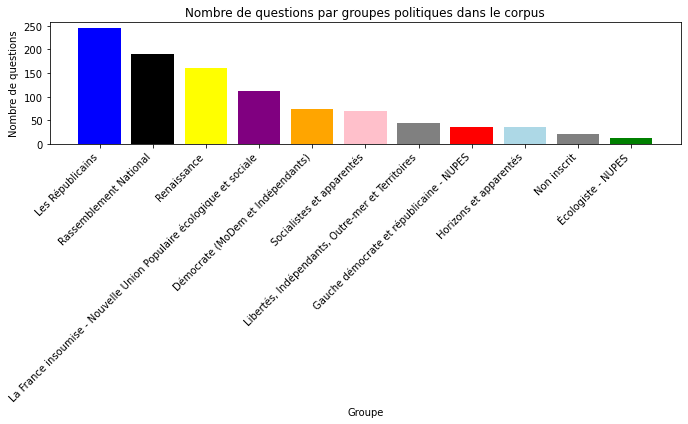

In [154]:
groupes = Counter(df_questions['groupe'].tolist())
plot_top_n_keys(groupes, 30, x="Groupe", y="Nombre de questions", title= f'Nombre de questions par groupes politiques dans le corpus')

## Partie II : Répartition des questions par département d'origine

In [155]:
liste_deputes = df_questions['nom'].tolist()

liste_meme_format = [entry.replace('M. ', '').replace('Mme ', '') for entry in liste_deputes]

mp_numbers = Counter(liste_meme_format)

In [156]:
departement_sums = {}

for departement, mp_list in departement_mp.items():
    sum_for_departement = sum(mp_numbers.get(mp, 0) for mp in mp_list)
    departement_sums[departement] = sum_for_departement

print(departement_sums)

{'Ain': 8, 'Isère': 4, 'Seine': 65, 'Haute': 27, 'Doubs': 4, 'Marne': 5, 'Aveyron': 3, 'Indre': 12, 'Bouches': 11, 'Rhône': 18, 'Paris': 11, 'Loire': 20, 'Essonne': 6, 'Français': 5, 'Drôme': 3, 'Charente': 9, 'Vaucluse': 3, 'Finistère': 3, 'Oise': 0, 'Mayenne': 7, 'Guadeloupe': 2, 'Aude': 5, 'La': 0, 'Deux': 3, 'Meurthe': 22, 'Aube': 4, 'Aisne': 7, 'Moselle': 8, 'Vendée': 3, 'Vienne': 3, 'Ille': 13, 'Yvelines': 6, 'Nord': 44, 'Gard': 3, 'Pas': 43, 'Val': 16, 'Pyrénées': 7, 'Calvados': 10, 'Maine': 4, 'Var': 25, 'Savoie': 5, 'Cantal': 0, 'Côte': 5, 'Côtes': 0, 'Territoire': 0, 'Gironde': 21, 'Hauts': 8, 'Allier': 1, 'Hautes': 6, 'Loiret': 23, 'Jura': 16, 'Ardèche': 10, 'Eure': 7, 'Bas': 14, 'Tarn': 5, 'Hérault': 9, 'Guyane': 0, 'Landes': 10, 'Gers': 1, 'Polynésie': 0, 'Puy': 14, 'Loir': 1, 'Alpes': 17, 'Corse': 1, 'Ardennes': 10, 'Cher': 1, 'Saône': 15, 'Lot': 5, 'Creuse': 1, 'Dordogne': 2, 'Sarthe': 11, 'Somme': 4, 'Corrèze': 0, 'Nouvelle': 1, 'Ariège': 0, 'Haut': 8, 'Vosges': 18, 'Ma

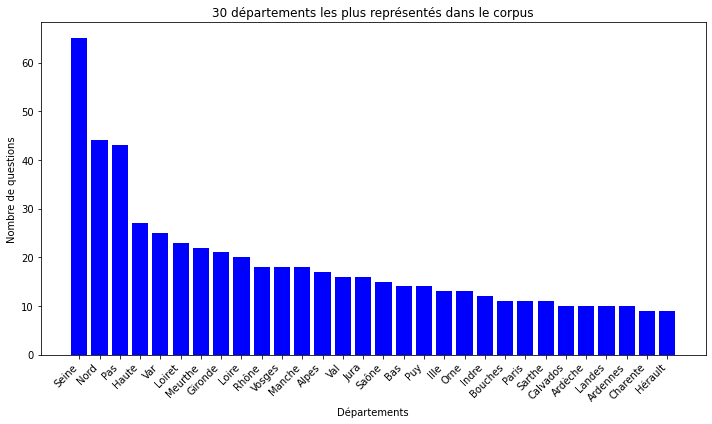

In [157]:
plot_top_n_keys(departement_sums, 30, x="Départements", y="Nombre de questions", title= f'{n} départements les plus représentés dans le corpus')

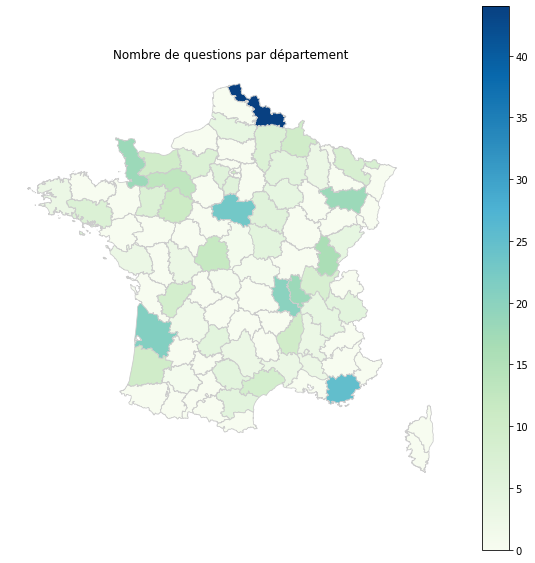

In [192]:
trace_carte(departement_sums,f"Nombre de questions par département")

## Partie III : Répartition des question par thématique : rubrique et ministère

In [159]:
ministere = Counter(df_questions['ministère_interrogé'].tolist())

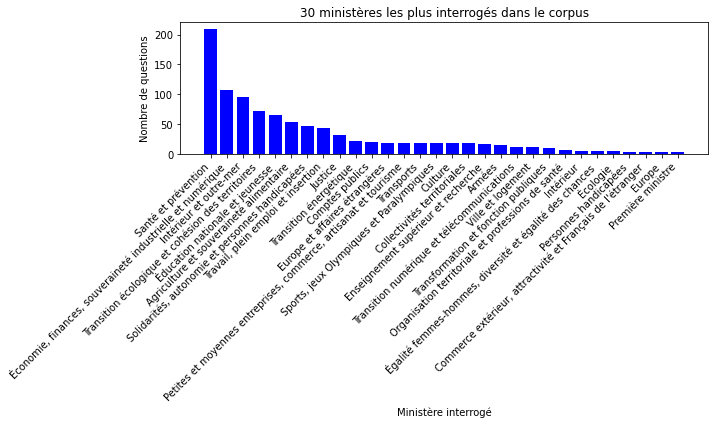

In [160]:
plot_top_n_keys(ministere, 30, x="Ministère interrogé", y="Nombre de questions", title= f'{n} ministères les plus interrogés dans le corpus')

## Partie IV : Etudes du contenu : nuages de mots


In [161]:
questions = " ".join(df_questions["question_clean"])

def clean_text(text):
    text = text.lower() 
    text = " ".join(text.split())
    return text

questions = clean_text(questions)


In [162]:
occurrences = WordCloud().process_text(questions)

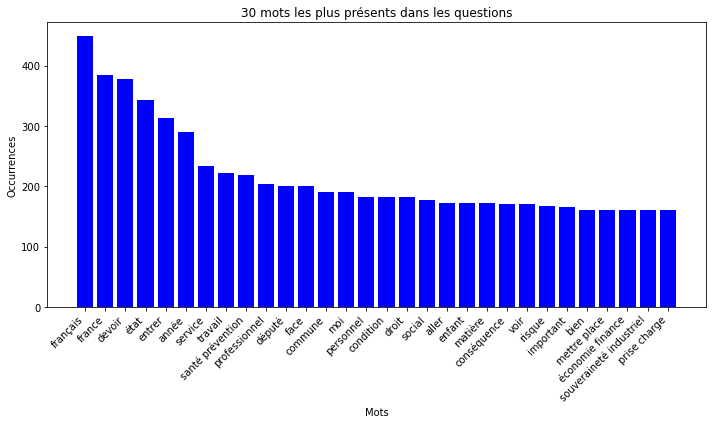

In [163]:
n=30

plot_top_n_keys(occurrences, n, x="Mots", y="Occurrences", title= f'{n} mots les plus présents dans les questions')

(-0.5, 959.5, 865.5, -0.5)

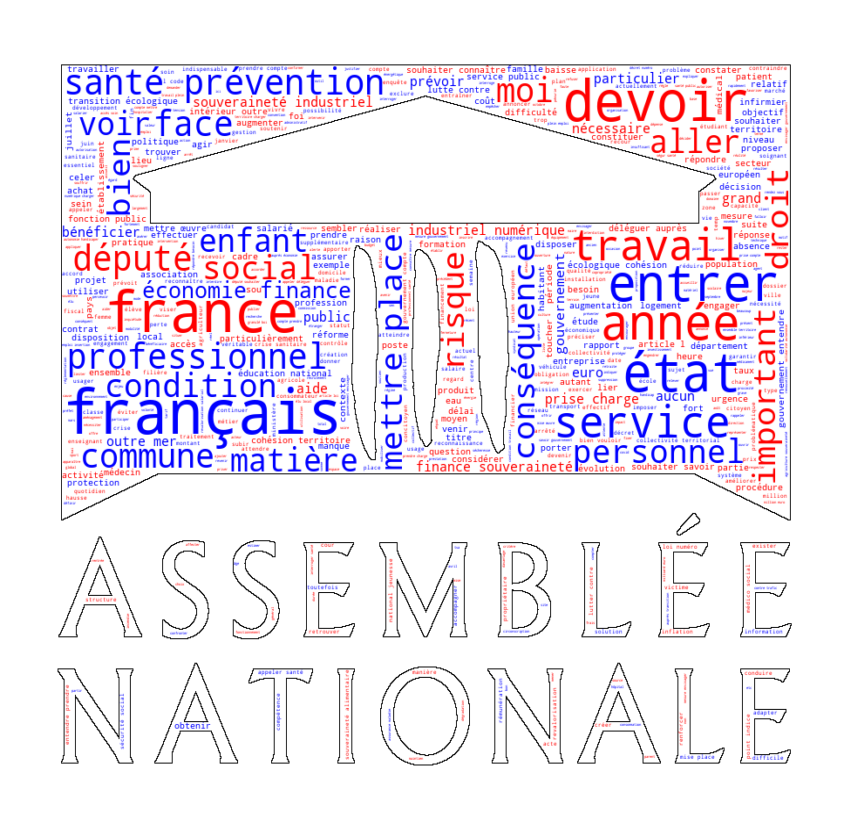

In [175]:
img = "https://upload.wikimedia.org/wikipedia/commons/a/ad/FRNationalAssemblyLogo.png"
an_mask = np.array(PIL.Image.open(io.BytesIO(requests.get(img).content)))

wc = wordcloud.WordCloud(background_color="white", max_words=200000, mask=an_mask, contour_width=0.1, contour_color='black').generate(questions)

def couleur(word, font_size, position, orientation, random_state=None, **kwargs):
    # Randomly choose between red and blue
    color = random.choice(['red', 'blue'])
    return color

plt.figure(figsize=(15, 15))
plt.imshow(wc.recolor(color_func=couleur), interpolation='bilinear', aspect='auto')
plt.axis("off")

## Partie V : Quelques mots discriminants : qui prononce quoi ? 

In [168]:
occurrences.get("violence")

25

In [169]:
def qui_prononce_quoi(target_word):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains(target_word)]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)
    plot_top_n_keys(dico_prononce, n=30, x="Groupe", y="Occurrences", title = f"Utilisation du mot '{target_word}' par groupe politique")

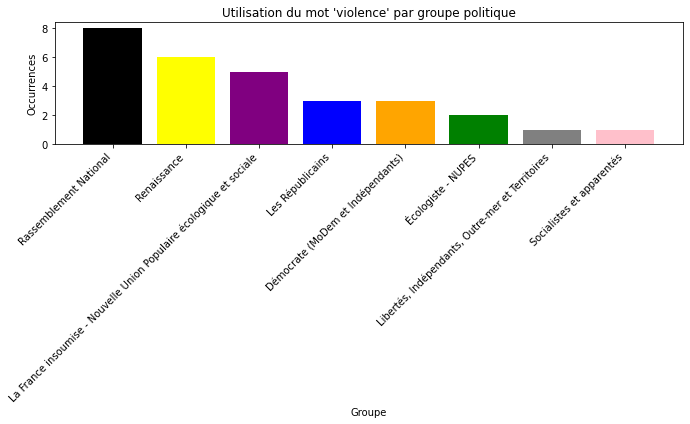

In [170]:
qui_prononce_quoi('violence')

Problème : surreprésentation de ceux qui posent le plus de question... 

On peut essayer de normaliser par le nombre de question posé par le groupe ! 

In [171]:
def qui_prononce_quoi_normalise(target_word):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains(target_word)]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)
    questions_par_groupe = Counter(df_questions['groupe'].tolist())

    dico_prononce_normalise = Counter({key : dico_prononce[key] / questions_par_groupe[key] for key in questions_par_groupe})


    plot_top_n_keys(dico_prononce_normalise, n=30, x="Groupe", y="Occurrences", title = f"Utilisation du mot '{target_word}' par groupe politique (normalisée)")

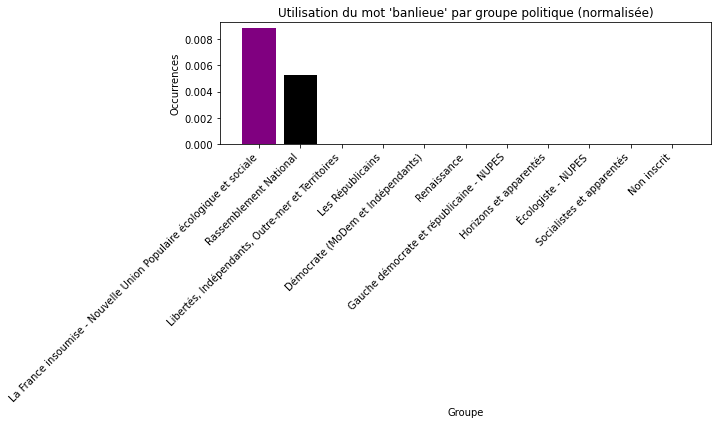

In [172]:
qui_prononce_quoi_normalise('banlieue')

In [173]:
def qui_prononce_quoi_camembert(target_word):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains(target_word)]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)

    dico_prononce = Counter(selection_lignes)
    questions_par_groupe = Counter(df_questions['groupe'].tolist())
    nb_questions = len(df_questions['groupe'].tolist())

    dico_prononce_normalise = Counter({key : dico_prononce[key] / questions_par_groupe[key] for key in questions_par_groupe})

    #pour avoir un affichage plus comode en enlevant les catégories non significatives
    dico_prononce_normalise_filtre = {cat: val for cat, val in dico_prononce_normalise.items() if val >= 1/nb_questions}

    categories = list(dico_prononce_normalise_filtre.keys())
    values = list(dico_prononce_normalise_filtre.values())

    colors = [dict_couleurs.get(cat, 'blue') for cat in categories]

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.axes(aspect='equal')  

    plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=90, colors=colors)

    #White center pour la lisibilité
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(f"Diagramme circulaire de l'usage du mot '{target_word}' par les groupes politiques")

    # Show the plot
    plt.show()

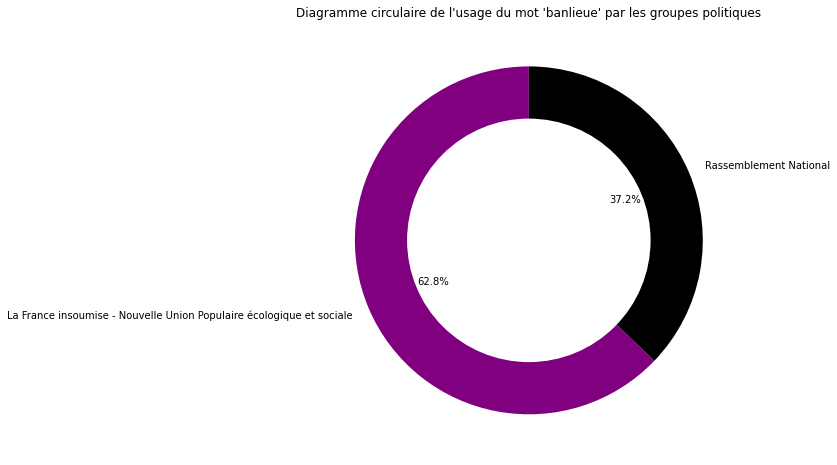

In [174]:
qui_prononce_quoi_camembert('banlieue')


On peut aussi regarder de quel département sont élus les députés qui prononcent ces mots :

In [176]:
target_word = "rural"

In [186]:
def localisation_mot(target_word):

    filtered_rows = df_questions[df_questions['question_clean'].str.contains(target_word)]
    selection_deputes = filtered_rows['nom'].tolist()
    liste_meme_format = [entry.replace('M. ', '').replace('Mme ', '') for entry in selection_deputes]

    mp_numbers = Counter(liste_meme_format)

    departement_sums = {}

    for departement, mp_list in departement_mp.items():
        sum_for_departement = sum(mp_numbers.get(mp, 0) for mp in mp_list)
        departement_sums[departement] = sum_for_departement

    
    plot_top_n_keys(departement_sums, n=30, x="Département", y="Occurrences", title = f"D'où sont issus les députés qui prononcent le mot '{target_word}' ?")
    trace_carte(departement_sums,f"D'où sont issus les députés qui prononcent le mot '{target_word}' ?")

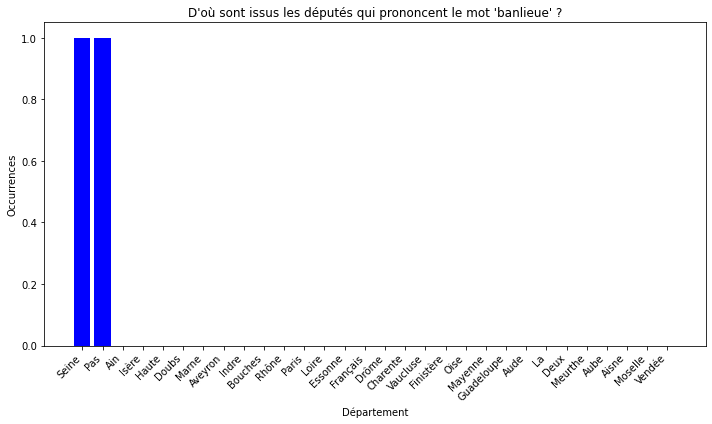

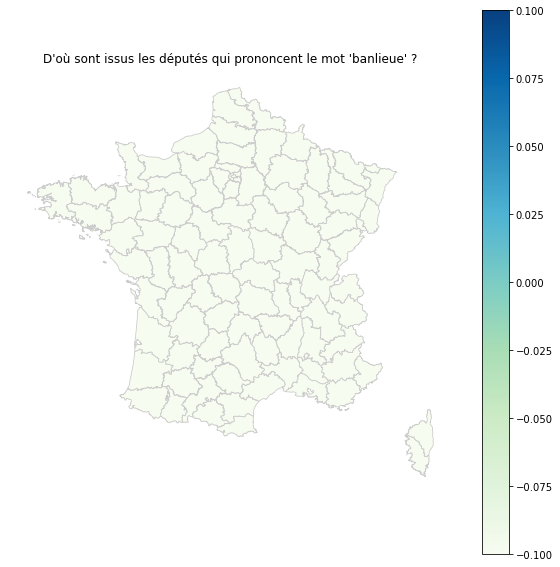

In [193]:
localisation_mot("banlieue")